In [2]:
# 1) Business Question, # 2) Data Collection, # 3) Preprocessing, # 4) Model(s) Creation, # 5) Model Evaluation and Comparison , # 6) Conclusion and Future Improvements
#https://www.kaggle.com/c/home-credit-default-risk/data?select=installments_payments.csv
#Dataframe
import pandas as pd
import numpy as np
import math
from datetime import datetime
import scipy
from scipy import stats
#Graph
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
#sklearn & models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from  sklearn.impute import SimpleImputer   
from imblearn.over_sampling import SMOTE
#Print 30 lines
pd.set_option('display.max_rows', 30)

In [8]:
#-----------------------------------------------------Data Preprocessing-----------------------------------------------------#

#Step 0:    #--------------------------------------------------------------->>>Load dataframe<<<
df = pd.read_csv("./data/application_train.csv" )           #index_col=0  ID which is used for mapping other excel files goes to index column
print('original shape: ' , df.shape)
df.drop(columns=['SK_ID_CURR','DAYS_BIRTH'], inplace=True)  #drop ID

#Step 1.1:    #--------------------------------------------------------------->>>categorical columns<<<   missing values
drop_rate = 1   #1 means drop nothing    #0.3 mean the data with 70% more  
drop_col_lst_1 = drop_col_lst_2 = drop_col_lst_3 = []

for col in df.columns:
    if (df[col].isna().sum() / df.shape[0] <= drop_rate )&(type(df[col][0])==str):
        df[col].fillna(  df[col].mode()[0]  ,inplace=True)  #   >>>categorical columns<<<   Minor missing values: replace with mode
    elif (df[col].isna().sum() / df.shape[0] > drop_rate )&(type(df[col][0])==str):
        drop_col_lst_1.append(col)                          #   >>>categorical columns<<<   Huge missing values:  drop

df.drop(columns=drop_col_lst_1 , inplace=True)

#Step 1.2:    #--------------------------------------------------------------->>>Numerical columns<<<   missing values
drop_col_lst_2 = [col for col in df.columns if (df[col].isna().sum() / df.shape[0] > drop_rate )&((type(df[col][0])==np.int64)|(type(df[col][0])==np.float64))]
df.drop(columns=drop_col_lst_2 , inplace=True)
#   Replace missing values with mean
df[list(df.select_dtypes(include=["int64","float64"]).columns)]  =  pd.DataFrame(   SimpleImputer(missing_values=np.NaN, strategy='mean').fit_transform(  df[list(df.select_dtypes(include=["int64","float64"]).columns)].values),index = df.index,columns=  list(df.select_dtypes(include=["int64","float64"]).columns) )   


#Step 1.3:    #---------------------------------------------------------------To drop columns with low correlation
# for col in df.columns:
#     try:
#         if (df_corr['Abs_correlation'][col] <=0.02):    #0.032131 > top 30
#             drop_col_lst_3.append(col) 
#     except:
#         continue
# df.drop(columns=drop_col_lst_3 , inplace=True)
# print('Columns that is dropped due to their low correlation: \n',drop_col_lst_3)

#Step 1.4:    #---------------------------------------------------------------Remove outliners
# print('df shape before outliners:' , df.shape)
# df = df[(np.abs( df[df.drop(columns='TARGET').select_dtypes(include=[np.number]).columns].apply(stats.zscore))       < float(3)).all(axis=1)]
# print('df shape after outliners:' , df.shape)
print('Columns that is dropped due to missing values: \n',drop_col_lst_1,drop_col_lst_2,drop_col_lst_3)

#Step 2:    #--------------------------------------------------------------->>>fix imbalanced dataset<<<   
df.drop(df.query('TARGET == 0').sample(((df.query('TARGET == 0').shape[0])-1*(df.query('TARGET == 1').shape[0]))).index,inplace=True)  #Downscale the data with '0'
print(df.TARGET.value_counts())

#Step 3:    #--------------------------------------------------------------->>>Numerical columns<<<   Standardization & Labelling
X = df.drop(columns=['TARGET'])
y = df[['TARGET']]

# Standardization (0 mean, 1 stdev) https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
# X[list(X.select_dtypes(include=["int64","float64"]).columns)] = pd.DataFrame(   StandardScaler().fit_transform(X[list(X.select_dtypes(include=["int64","float64"]).columns)].values), index = X.index, columns = list(X[list(X.select_dtypes(include=["int64","float64"]).columns)].columns))   

#MinMaxScaler
# X[list(X.select_dtypes(include=["int64","float64"]).columns)] = pd.DataFrame(   MinMaxScaler(feature_range=(0, 1)).fit_transform(X[list(X.select_dtypes(include=["int64","float64"]).columns)].values), index = X.index, columns = list(X[list(X.select_dtypes(include=["int64","float64"]).columns)].columns)) 

#Step 4:    #--------------------------------------------------------------->>>categorical columns<<<   One Hot Encoder  
X= pd.get_dummies(X, drop_first=True)       

print('X.shape = ' , X.shape)
y.head()
X.head()

original shape:  (307511, 122)
Columns that is dropped due to missing values: 
 [] [] []
0.0    24825
1.0    24825
Name: TARGET, dtype: int64
X.shape =  (49650, 224)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,-3648.0,-2120.0,12.061091,...,0,0,0,0,0,0,0,1,0,0
25,0.0,90000.0,225000.0,11074.5,225000.0,0.028663,-3494.0,-2419.0,-2893.0,12.061091,...,0,0,0,0,0,0,0,1,0,0
26,0.0,112500.0,979992.0,27076.5,702000.0,0.018029,-2628.0,-6573.0,-1827.0,12.061091,...,0,0,0,0,0,0,0,0,1,1
34,0.0,135000.0,1125000.0,32895.0,1125000.0,0.019689,-4585.0,-5735.0,-4067.0,12.061091,...,0,0,0,0,0,0,0,1,0,0
40,0.0,202500.0,1193580.0,35028.0,855000.0,0.025164,-1262.0,-1182.0,-1029.0,12.061091,...,0,0,0,0,0,0,0,1,0,0


In [9]:
import time
start_time = time.time()

#   RamdonForest                       #---------------------Modelling---------------------#
#No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , stratify=y)

rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42 )  #, max_leaf_nodes=16, bootstrap=False
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

print("Process finished --- %s seconds ---" % (time.time() - start_time))

confusion_matrix:    
 [[6834 3096]
 [3273 6657]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.69      0.68      9930
         1.0       0.68      0.67      0.68      9930

    accuracy                           0.68     19860
   macro avg       0.68      0.68      0.68     19860
weighted avg       0.68      0.68      0.68     19860

accuracy_score:  
 0.6793051359516616  ; with data size of  (29790, 224)
Process finished --- 3.5661780834198 seconds ---


In [2]:
#Presentation:      refer to word file
#Pros and Cons:     https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6

In [3]:
#To Do: Plot graph

In [4]:
#To Do: Add excel files
# df_bureau = pd.read_csv("./data/bureau.csv" ) 
# df.join(df_bureau, on='SK_ID_CURR', how='outer')

# df_ori = pd.read_csv("./data/application_train.csv" ) #  index_col=0  ID which is used for mapping other excel files goes to index column
# df_ori.TARGET.value_counts()
# df_ori.groupby(by='TARGET')['AMT_CREDIT'].sum()

In [5]:
#Before data cleaning
df = pd.read_csv("./data/application_train.csv" )
#   Numerical data 
df[list(df.select_dtypes(include=["int64","float64"]).columns)]     =       pd.DataFrame(   SimpleImputer(missing_values=np.NaN, strategy='mean').fit_transform(  df[list(df.select_dtypes(include=["int64","float64"]).columns)].values),index = df.index,columns=  list(df.select_dtypes(include=["int64","float64"]).columns) )  
#   Categorical data
for col in df.columns:
    df[col].fillna(  df[col].mode()[0]  ,inplace=True)  #   >>>categorical columns<<<   Minor missing values

X = df.drop(columns=['TARGET'])
y = df[['TARGET']]
#One Hot Encoder
X= pd.get_dummies(X, drop_first=True)       
#End
print('X.shape = ' , X.shape)

X.shape =  (307511, 229)


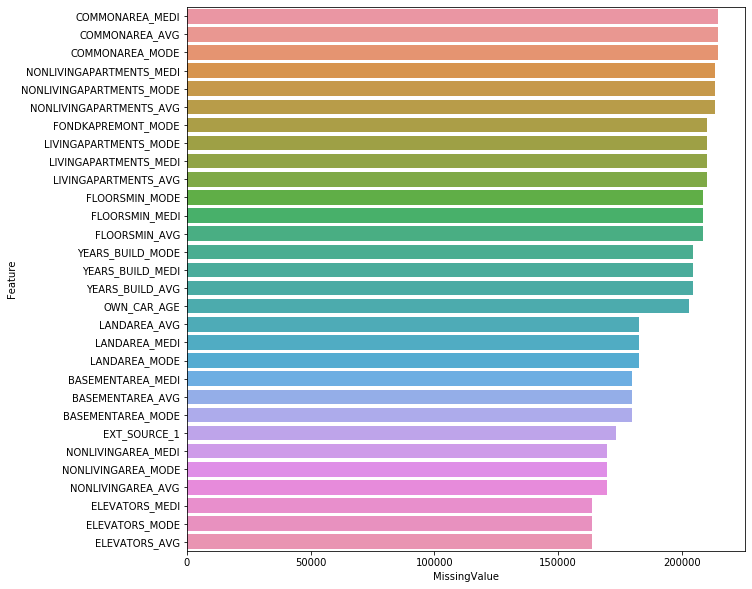

In [6]:
df = pd.read_csv("./data/application_train.csv" )

MissingColumns = []
MissingValues = []
for col in df.columns:
    if int(df[col].isna().sum()) != 0:
        MissingColumns.append(col)
        MissingValues.append(df[col].isna().sum())
missing_df = pd.DataFrame(list(zip(MissingColumns, MissingValues)), columns =['Feature', 'MissingValue']) 
missing_df.sort_values(by=['MissingValue'],ascending=False,inplace=True)
missing_df.reset_index(drop=True, inplace=True)
#sns.factorplot(df=missing_df , x = 'MissingValue' , y = 'Feature' )
missing_df.head(30)
fig , ax = plt.subplots(figsize = (10,10))
sns.barplot(data=missing_df.head(30) , x = 'MissingValue' , y = 'Feature' )

In [9]:
import time
start_time = time.time()

#   RamdonForest                       #---------------------Modelling---------------------#
#No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , stratify=y)

rnd_clf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42 )  #, max_leaf_nodes=16, bootstrap=False
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

print("Process finished --- %s seconds ---" % (time.time() - start_time))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


confusion_matrix:    
 [[6761 3169]
 [3193 6737]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      9930
         1.0       0.68      0.68      0.68      9930

    accuracy                           0.68     19860
   macro avg       0.68      0.68      0.68     19860
weighted avg       0.68      0.68      0.68     19860

accuracy_score:  
 0.6796576032225579  ; with data size of  (29790, 225)
Process finished --- 40.77419972419739 seconds ---


In [11]:
import time
start_time = time.time()

#XGboost
print('-------XGboost-------')
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size =0.2, random_state=42, stratify = y)
#SMOTE: too many False Negative
print(X.shape)

model =XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)


print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------XGboost-------
(49650, 225)
[17:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix:    
 [[3230 1735]
 [1517 3448]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.65      0.67      4965
         1.0       0.67      0.69      0.68      4965

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

accuracy_score:  
 0.6725075528700907  ; with data size of  (39720, 225)
Process finished --- 5.215563535690308 seconds ---


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-------Regression model-------
X_train shape is:   (39720, 225)
confusion_matrix:    
 [[3150 1815]
 [2370 2595]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.57      0.63      0.60      4965
         1.0       0.59      0.52      0.55      4965

    accuracy                           0.58      9930
   macro avg       0.58      0.58      0.58      9930
weighted avg       0.58      0.58      0.58      9930

accuracy_score:  
 0.5785498489425982  ; with data size of  (39720, 225)
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00002
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00001
Feature: 8, Score: 0.00001
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Featu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


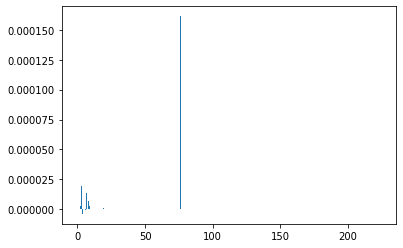

In [12]:
#Regression model       #---------------------Modelling---------------------#
print('-------Regression model-------')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
print('X_train shape is:  ', X_train.shape)
# print('Sample size before SMOTE method: ' , X_train.shape)    
# X_train,y_train = SMOTE(random_state = 42, k_neighbors = 3).fit_resample(X_train,y_train)     #SMOTE: too many False Negative
# print('Sample size after SMOTE method: ' , X_train.shape)
#Oversampling the data     ## https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5

logmodel = LogisticRegression()     # Create instance (i.e. object) of LogisticRegression
logmodel.fit(X_train, y_train)      # Fit the model using the training data
y_pred = logmodel.predict(X_test)   #Predicting the target for test data

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

# get importance
importance = logmodel.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)     #range(len(importance))
pyplot.show()

In [13]:
#   KNN                                    #---------------------Modelling---------------------#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
#SMOTE: too slow , run like 1 hour for data set with ~300k size

knn = KNeighborsClassifier(n_neighbors=5)   #Make an object
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


confusion_matrix:    
 [[2654 2311]
 [2159 2806]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.55      0.53      0.54      4965
         1.0       0.55      0.57      0.56      4965

    accuracy                           0.55      9930
   macro avg       0.55      0.55      0.55      9930
weighted avg       0.55      0.55      0.55      9930

accuracy_score:  
 0.5498489425981873  ; with data size of  (39720, 225)


In [14]:
#   RamdonForest                       #---------------------Modelling---------------------#
#No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)       #

# print('Sample size before SMOTE method: ' , X_train.shape)
# X_train,y_train = SMOTE(random_state = 42).fit_resample(X_train,y_train)
# print('Sample size after SMOTE method: ' , X_train.shape)

#---------------------Modelling---------------------#  RamdonForest > unlimitted depth and leaf
rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)  #, max_leaf_nodes=16
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

# #---------------------Modelling---------------------#  Multiclass classification with under-sampling
# print(type(y_train))
# print('Training target statistics: {}'.format(Counter(y_train)))
# print('Testing target statistics: {}'.format(Counter(y_test)))
# # Create a pipeline
# pipeline = make_pipeline(NearMiss(version=2),
#                          LinearSVC(random_state=42))
# pipeline.fit(X_train, y_train)

#---------------------Modelling---------------------#  AdaBoost#;   RamdonForest > unlimitted depth and leaf
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier

# ada_clf = AdaBoostClassifier(
#     #DecisionTreeClassifier(max_depth=2), n_estimators=200,learning_rate=0.05, random_state=42)
#     DecisionTreeClassifier(), n_estimators=200,learning_rate=0.05, random_state=42)
# ada_clf.fit(X_train, y_train)
# y_pred = ada_clf.predict(X_test)

# # #5.1 - Hyperparameter Tuning (Max Depth)#---------------------Modelling---------------------#  Find Max depth
# # parameters = {'max_depth' : list(range(1,11))}
# # from sklearn.model_selection import GridSearchCV
# # search = GridSearchCV(DecisionTreeClassifier(),param_grid=parameters,cv=10)
# # search.fit(X_train,y_train)
# # print('search.best_score_:' , search.best_score_)
# # print('search.best_params_:', search.best_params_)

# # #5.2 - Hyperparameter Tuning (Max Depth)#---------------------Modelling---------------------#  List all score of diff depth
# # # List of values to try for max_depth:
# # max_depth_range = list(range(1, 11))
# # # List to store the accuracy for each value of max_depth:
# # accuracy = []
# # for depth in max_depth_range:
    
# #     clf = DecisionTreeClassifier(max_depth = depth, random_state=0)
# #     clf.fit(X_train, y_train)
# #     score = clf.score(X_test, y_test)
# #     accuracy.append(score)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
from sklearn.metrics import confusion_matrix
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative
''')
from sklearn.metrics import classification_report
print('classification_report:   \n',    classification_report(y_test, y_pred))
from sklearn.metrics import accuracy_score
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)
#--Other models--

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


confusion_matrix:    
 [[3327 1638]
 [1600 3365]]

True positive      False positive
False Negative      True negative

classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.67      0.67      4965
         1.0       0.67      0.68      0.68      4965

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

accuracy_score:  
 0.6739174219536758  ; with data size of  (39720, 225)


In [15]:
# from imblearn.ensemble import BalancedRandomForestClassifier
# from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=1000, n_classes=3,
#                            n_informative=4, weights=[0.2, 0.3, 0.5],
#                            random_state=0)
                        
# clf = BalancedRandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)  
# print(pd.DataFrame(X))
# print('feature_importances_' , clf.feature_importances_)  
# print(clf.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))
# X.shape

In [16]:
# #https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html
# # Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# # License: MIT

# from collections import Counter

# from sklearn.datasets import load_iris
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import train_test_split

# from imblearn.datasets import make_imbalance
# from imblearn.under_sampling import NearMiss
# from imblearn.pipeline import make_pipeline
# from imblearn.metrics import classification_report_imbalanced

# print(__doc__)

# RANDOM_STATE = 42

# # Create a folder to fetch the dataset
# iris = load_iris()
# X, y = make_imbalance(iris.data, iris.target,
#                       sampling_strategy={0: 25, 1: 50, 2: 50},
#                       random_state=RANDOM_STATE)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=RANDOM_STATE)

# print('Training target statistics: {}'.format(Counter(y_train)))
# print('Testing target statistics: {}'.format(Counter(y_test)))

# # Create a pipeline
# pipeline = make_pipeline(NearMiss(version=2),
#                          LinearSVC(random_state=RANDOM_STATE))
# pipeline.fit(X_train, y_train)

# # Classify and report the results
# print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

In [17]:
##LGBMClassifier

In [18]:
#Correlation preset ------------ part 1
df = pd.read_csv("./data/application_train.csv" )
df_corr = pd.DataFrame( df.corr()['TARGET'])
df_corr['MissingValue'] = [df[list(df_corr.index)[x]].isna().sum() for x in range(len(pd.DataFrame(df_corr)['TARGET']))]
#df_corr = df_corr[df_corr['MissingValue']>30000].sort_values(by=['TARGET'])
df_corr['Abs_correlation'] = abs(df_corr['TARGET'])
df_corr.sort_values(by=['Abs_correlation'],ascending=False,inplace=True)
print(df_corr)
print(len(list(df_corr.index)))
"','".join(list(df_corr.index))

# #Correlation preset ------------ part 2

# pd.set_option('display.max_rows', None)

# #Keep certain percent
# df_corr_Work = df_corr[(df_corr['TARGET']>=-0.04)&(df_corr['TARGET']<=0.04)]
# print('shape: ',df_corr_Work.shape)
# print(df_corr_Work)
# print(list(df_corr_Work.index))

                    TARGET  MissingValue  Abs_correlation
TARGET            1.000000             0         1.000000
EXT_SOURCE_3     -0.178919         60965         0.178919
EXT_SOURCE_2     -0.160472           660         0.160472
EXT_SOURCE_1     -0.155317        173378         0.155317
DAYS_BIRTH        0.078239             0         0.078239
...                    ...           ...              ...
FLAG_DOCUMENT_12 -0.000756             0         0.000756
FLAG_MOBIL        0.000534             0         0.000534
FLAG_CONT_MOBILE  0.000370             0         0.000370
FLAG_DOCUMENT_5  -0.000316             0         0.000316
FLAG_DOCUMENT_20  0.000215             0         0.000215

[106 rows x 3 columns]
106


"TARGET','EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY','FLAG_EMP_PHONE','DAYS_EMPLOYED','REG_CITY_NOT_LIVE_CITY','FLAG_DOCUMENT_3','FLOORSMAX_AVG','FLOORSMAX_MEDI','FLOORSMAX_MODE','DAYS_REGISTRATION','AMT_GOODS_PRICE','OWN_CAR_AGE','REGION_POPULATION_RELATIVE','ELEVATORS_AVG','ELEVATORS_MEDI','FLOORSMIN_AVG','FLOORSMIN_MEDI','LIVINGAREA_AVG','LIVINGAREA_MEDI','FLOORSMIN_MODE','TOTALAREA_MODE','LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','ELEVATORS_MODE','DEF_60_CNT_SOCIAL_CIRCLE','LIVINGAREA_MODE','AMT_CREDIT','APARTMENTS_AVG','APARTMENTS_MEDI','FLAG_DOCUMENT_6','FLAG_WORK_PHONE','APARTMENTS_MODE','LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI','HOUR_APPR_PROCESS_START','FLAG_PHONE','LIVINGAPARTMENTS_MODE','BASEMENTAREA_AVG','YEARS_BUILD_MEDI','YEARS_BUILD_AVG','BASEMENTAREA_MEDI','YEARS_BUILD_MODE','BASEMENTAREA_MODE','AMT_REQ_CREDIT_BUREAU_YEAR'

In [19]:
df_corr_top20 = df_corr[(df_corr['Abs_correlation']>=0.034199)]
df_corr_top20.drop('TARGET',inplace=True)
print(df_corr_top20)

df_corr_top20.columns=['Correlation','Count_MissingValues','Abs_correlation']
df_corr_top20

                               TARGET  MissingValue  Abs_correlation
EXT_SOURCE_3                -0.178919         60965         0.178919
EXT_SOURCE_2                -0.160472           660         0.160472
EXT_SOURCE_1                -0.155317        173378         0.155317
DAYS_BIRTH                   0.078239             0         0.078239
REGION_RATING_CLIENT_W_CITY  0.060893             0         0.060893
REGION_RATING_CLIENT         0.058899             0         0.058899
DAYS_LAST_PHONE_CHANGE       0.055218             1         0.055218
DAYS_ID_PUBLISH              0.051457             0         0.051457
REG_CITY_NOT_WORK_CITY       0.050994             0         0.050994
FLAG_EMP_PHONE               0.045982             0         0.045982
DAYS_EMPLOYED               -0.044932             0         0.044932
REG_CITY_NOT_LIVE_CITY       0.044395             0         0.044395
FLAG_DOCUMENT_3              0.044346             0         0.044346
FLOORSMAX_AVG               -0.044

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Correlation,Count_MissingValues,Abs_correlation
EXT_SOURCE_3,-0.178919,60965,0.178919
EXT_SOURCE_2,-0.160472,660,0.160472
EXT_SOURCE_1,-0.155317,173378,0.155317
DAYS_BIRTH,0.078239,0,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893,0,0.060893
REGION_RATING_CLIENT,0.058899,0,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218,1,0.055218
DAYS_ID_PUBLISH,0.051457,0,0.051457
REG_CITY_NOT_WORK_CITY,0.050994,0,0.050994
FLAG_EMP_PHONE,0.045982,0,0.045982
